In [1]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sn

from gene_variation_effects import config
from gene_variation_effects.modeling import NNPipeLine, MLP, data_shuffle_split, run_training_loop, test_model


seed = 42

DATASET_NAME = 'dataset.csv'
TARGET_FEATURE = 'ClinSigSimple'
df = pd.read_csv(os.path.join(config.DATA_DIR, DATASET_NAME))
target_array = df[TARGET_FEATURE]

df.drop(columns=[TARGET_FEATURE], inplace=True)
# df.drop(columns=['Type', 'GeneSymbol', 'VariantLength', 'VariantLengthDifference'], inplace=True)

ONEHOT_FEATURES = ['Type']
EMBEDDED_FEATURES = ['GeneSymbol']
NUMERIC_FEATURES = ['VariantLength', 'VariantLengthDifference']
pipeline = NNPipeLine(df.columns, ONEHOT_FEATURES, EMBEDDED_FEATURES, NUMERIC_FEATURES)

2025-11-02 19:34:47.083 | INFO     | gene_variation_effects.config:<module>:11 - PROJ_ROOT path is: /Users/jeffbrin/Desktop/gene-variation-effects-ml


In [2]:
# Split the data
TEST_SIZE = 0.1
VALIDATION_SIZE = 0.1
training_data, validation_data, test_data, training_target_array, validation_target_array, test_target_array = \
    data_shuffle_split(df.to_numpy(), target_array, TEST_SIZE, VALIDATION_SIZE, seed)

In [3]:
# Make sure input has no nan (it messed up the nn)
pd.isna(df.to_numpy()).any()

np.False_

In [4]:
# Fit pipeline and transform data
transformed_X_training, feature_processor = pipeline.fit_feature_transformations(training_data)
transformed_X_training = torch.Tensor(transformed_X_training)
transformed_X_validation = torch.Tensor(feature_processor.transform(validation_data))
transformed_X_test = torch.Tensor(feature_processor.transform(test_data))

training_target_array = torch.unsqueeze(torch.Tensor(training_target_array.to_numpy()), 1)
validation_target_array =  torch.unsqueeze(torch.Tensor(validation_target_array.to_numpy()), 1)
test_target_array =  torch.unsqueeze(torch.Tensor(test_target_array.to_numpy()), 1)

In [5]:
# TODO: Idk if I did something weird here
# TODO: Move to pipeline
# Getting input sizes for embedding layer
embedding_processor = feature_processor.named_transformers_['high_cardinality']
label_encoder = embedding_processor.named_steps['label_encode']

extra_cat_for_potential_unknown = 1 if label_encoder.handle_unknown == 'use_encoded_value' else 0
if hasattr(label_encoder, "categories_"):
    embedding_input_sizes = [cat.size + extra_cat_for_potential_unknown for cat in label_encoder.categories_]
else:
    embedding_input_sizes = []

In [24]:
# We only have one embedding input size right now, since we're doing this by hand anyways we can probably hard-code each one
# going forward. Maybe there is a way to automate this.
HIDDEN_SIZES = [256, 128, 64]
DROPOUT = 0
if len(embedding_input_sizes) > 0:
    GENE_LABELS_EMBEDDING_SIZE = int(embedding_input_sizes[0] ** 0.5)
    embedding_dimension_mapping = np.array([[embedding_input_sizes[0], GENE_LABELS_EMBEDDING_SIZE]])
else:
    embedding_dimension_mapping = np.array([])
model = MLP(embedding_dimension_mapping, HIDDEN_SIZES, transformed_X_training.shape[1], DROPOUT)

2025-11-02 19:36:37.111 | INFO     | gene_variation_effects.modeling.train:run_training_loop:129 - Epoch 1: accuracy=0.5073
2025-11-02 19:36:37.111 | INFO     | gene_variation_effects.modeling.train:run_training_loop:130 - Epoch 1: validation accuracy=0.4917
2025-11-02 19:36:37.111 | INFO     | gene_variation_effects.modeling.train:run_training_loop:131 - Epoch 1: validation loss=0.7138
2025-11-02 19:36:37.130 | INFO     | gene_variation_effects.modeling.train:run_training_loop:129 - Epoch 2: accuracy=0.4932
2025-11-02 19:36:37.130 | INFO     | gene_variation_effects.modeling.train:run_training_loop:130 - Epoch 2: validation accuracy=0.4922
2025-11-02 19:36:37.130 | INFO     | gene_variation_effects.modeling.train:run_training_loop:131 - Epoch 2: validation loss=1.1839
2025-11-02 19:36:37.239 | INFO     | gene_variation_effects.modeling.train:run_training_loop:129 - Epoch 3: accuracy=0.4883
2025-11-02 19:36:37.239 | INFO     | gene_variation_effects.modeling.train:run_training_loop:130

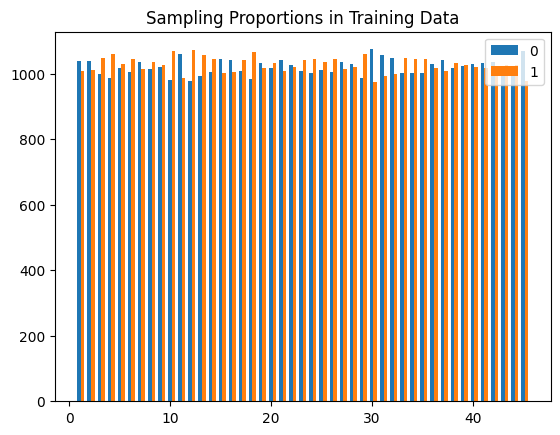

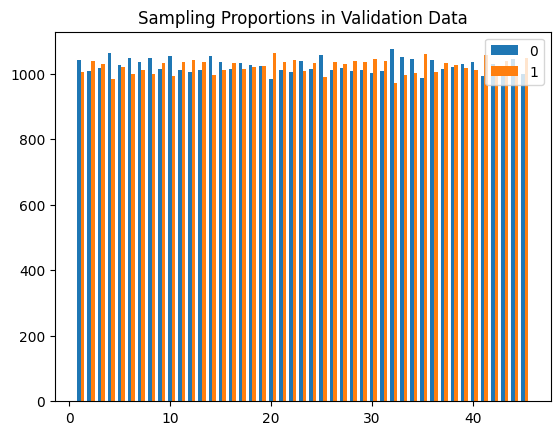

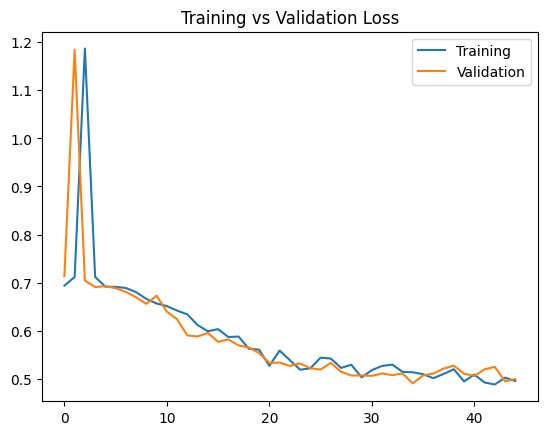

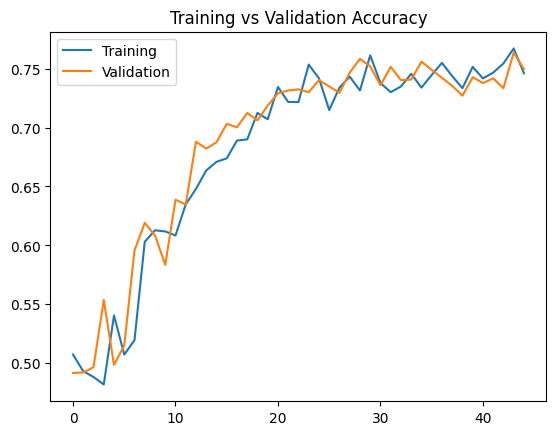

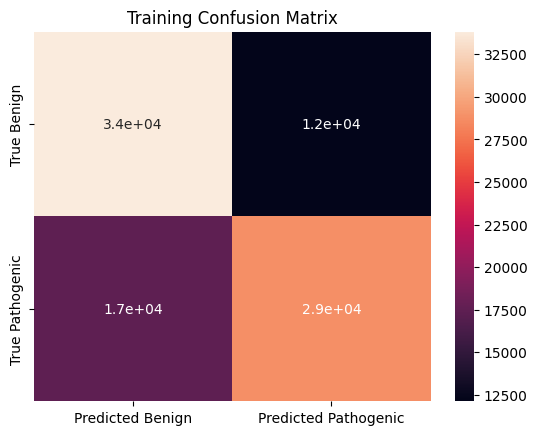

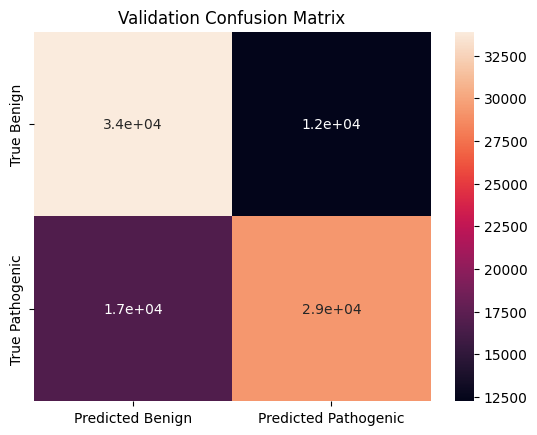

<Figure size 640x480 with 0 Axes>

In [ ]:
# Get indices for columns using embedding
features_indices = {feat: i for i, feat in enumerate(feature_processor.get_feature_names_out())}
embedding_features_indices = [ind for feat, ind in features_indices.items() if feat.startswith('high_cardinality')]
BATCH_SIZE = 2048
PATIENCE = 10
POSITIVE_THRESHOLD = 0.475

optimizer = torch.optim.Adam(model.parameters(), lr=2e-2)
optimal_model_dict, training_losses, val_losses, training_accuracies, val_accuracies, \
    training_confusion_matrix, val_confusion_matrix = run_training_loop(
    model, BATCH_SIZE, transformed_X_training, transformed_X_validation, training_target_array, 
    validation_target_array, embedding_features_indices, patience=PATIENCE, positive_threshold=POSITIVE_THRESHOLD,
    positive_class_loss_weight=torch.Tensor([1]),
    optimizer=optimizer)
torch.save(optimal_model_dict, "../models/model.pth")


plt.plot(training_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()
plt.clf()

plt.plot(training_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()
plt.clf()

cm_indices = ["True Benign", "True Pathogenic"]
cm_cols = ["Predicted Benign", "Predicted Pathogenic"]
training_confusion_matrix_df = pd.DataFrame(training_confusion_matrix, index = cm_indices, columns = cm_cols)
val_confusion_matrix_df = pd.DataFrame(val_confusion_matrix, index = cm_indices, columns = cm_cols)
# plt.matshow(training_confusion_matrix_df)
# plt.matshow(val_confusion_matrix_df)
sn.heatmap(training_confusion_matrix_df, annot=True)
plt.title("Training Confusion Matrix")
plt.show()
plt.clf()
sn.heatmap(val_confusion_matrix_df, annot=True)
plt.title("Validation Confusion Matrix")
plt.show()
plt.clf()

In [21]:
# The proportion of predicted pathogenic which are correct
precision = training_confusion_matrix_df['Predicted Pathogenic']['True Pathogenic'] / sum(training_confusion_matrix_df['Predicted Pathogenic'])
# Proportion of actual pathogenic variants which were predicted correctly
recall = training_confusion_matrix_df['Predicted Pathogenic']['True Pathogenic'] / sum(training_confusion_matrix_df.loc['True Pathogenic'])
# Proportion of actual benign which were predicted correctly
specificity = training_confusion_matrix_df['Predicted Benign']['True Benign'] / sum(training_confusion_matrix_df.loc['True Benign'])

print(precision)
print(recall)
print(specificity)

0.6678483973538979
0.7249608220428081
0.6360505396367714


In [22]:
# Recreate the model structure
model.load_state_dict(torch.load("../models/model.pth"))

<All keys matched successfully>

In [23]:
avg_loss, accuracy = test_model(model, BATCH_SIZE, transformed_X_test, test_target_array, embedding_features_indices)
avg_loss, accuracy

(0.4917244498679491, tensor(0.7559))